# Final Project

Do charges directly correlate with churn? predicting customer behavior, chrun rate, cost sensitivity & value. 

The telecom operator Interconnect would like to be able to forecast their churn of clients. If it's discovered that a user is planning to leave, they will be offered promotional codes and special plan options. Interconnect's marketing team has collected some of their clientele's personal data, including information about their plans and contracts.

I will make models that show if charges directly correlate with churn rate so we can then begin predicting customer behavior, their cost sensitivity & their values. 

## Initialization

In [1]:
import pandas as pd

import matplotlib.pyplot as plt
import matplotlib
import matplotlib.dates as mdates
from datetime import datetime

import lightgbm as lgb
from sklearn.svm import SVR
from scipy import signal
import seaborn as sns
import spacy
from sklearn import metrics


from sklearn.preprocessing import OneHotEncoder
import sklearn.metrics as metrics
from sklearn.dummy import DummyClassifier
from sklearn.model_selection import TimeSeriesSplit
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import GridSearchCV
import statsmodels.api as sm

from sklearn.model_selection import train_test_split
from sklearn.model_selection import cross_val_score

from sklearn.metrics import roc_auc_score
from sklearn.model_selection import RandomizedSearchCV

from sklearn.metrics import accuracy_score
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import mean_squared_error, r2_score, make_scorer
from sklearn.ensemble import RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier
from xgboost import XGBClassifier

## Load Data

In [2]:
df_contract = pd.read_csv('/datasets/contract.csv')
df_personal = pd.read_csv('/datasets/personal.csv')
df_internet = pd.read_csv('/datasets/internet.csv')
df_phone = pd.read_csv('/datasets/phone.csv')

## EDA

In [3]:
df_contract.head()

,customerID,BeginDate,EndDate,Type,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.5
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65


### Contract

In [4]:
df_contract['BeginDate'] = pd.to_datetime(df_contract['BeginDate'])

In [5]:
df_contract.columns = df_contract.columns.str.lower()

In [6]:
print("Earliest begin date:", df_contract['begindate'].min())
print("Latest begin date:", df_contract['begindate'].max())

Earliest begin date: 2013-10-01 00:00:00
Latest begin date: 2020-02-01 00:00:00


In [7]:
# First, let's see what unique values we have
print("Unique enddate values (first 10):")
print(df_contract['enddate'].unique()[:10])

Unique enddate values (first 10):
['No' '2019-12-01 00:00:00' '2019-11-01 00:00:00' '2019-10-01 00:00:00'
 '2020-01-01 00:00:00']


In [8]:
# Filter out 'No' values and look at actual dates
actual_enddates = df_contract[df_contract['enddate'] != 'No']['enddate']
print("Earliest end date:", actual_enddates.min())
print("Latest end date:", actual_enddates.max())

Earliest end date: 2019-10-01 00:00:00
Latest end date: 2020-01-01 00:00:00


In [9]:
df_contract.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype         
---  ------            --------------  -----         
 0   customerid        7043 non-null   object        
 1   begindate         7043 non-null   datetime64[ns]
 2   enddate           7043 non-null   object        
 3   type              7043 non-null   object        
 4   paperlessbilling  7043 non-null   object        
 5   paymentmethod     7043 non-null   object        
 6   monthlycharges    7043 non-null   float64       
 7   totalcharges      7043 non-null   object        
dtypes: datetime64[ns](1), float64(1), object(6)
memory usage: 440.3+ KB


In [10]:
df_contract.duplicated().sum()

0

In [11]:
df_contract.isna().sum()

customerid          0
begindate           0
enddate             0
type                0
paperlessbilling    0
paymentmethod       0
monthlycharges      0
totalcharges        0
dtype: int64

In [12]:
len(df_contract[df_contract['enddate'] == 'No']) / len(df_contract['enddate'])

0.7346301292063041

In [13]:
len(df_contract[df_contract['enddate'] != 'No']) / len(df_contract['enddate'])

0.2653698707936959

### Contract (Churned Customers)

In [14]:
# Churned customers (have an end date)
churned_customers = df_contract[df_contract['enddate']!= 'No']

# Active customers (no end date)
active_customers = df_contract[df_contract['enddate']== 'No']

In [20]:
churned_customers = churned_customers.copy()
churned_customers['enddate'] = pd.to_datetime(churned_customers['enddate'])

In [27]:
tenure=churned_customers['enddate']- churned_customers['begindate']
tenure

2        61 days
4        61 days
5       245 days
8       853 days
13     1491 days
          ...   
7021    365 days
7026    273 days
7032     31 days
7034   2040 days
7041    123 days
Length: 1869, dtype: timedelta64[ns]

In [ ]:
# First, I make sure the date columns are in datetime format
churned_customers['begindate'] = pd.to_datetime(churned_customers['begindate'])
churned_customers['enddate'] = pd.to_datetime(churned_customers['enddate'])

# Calculate tenure in months
churned_customers['tenure_month'] = (
    (churned_customers['enddate'] - churned_customers['begindate']).dt.days / 30
).round().astype(int)

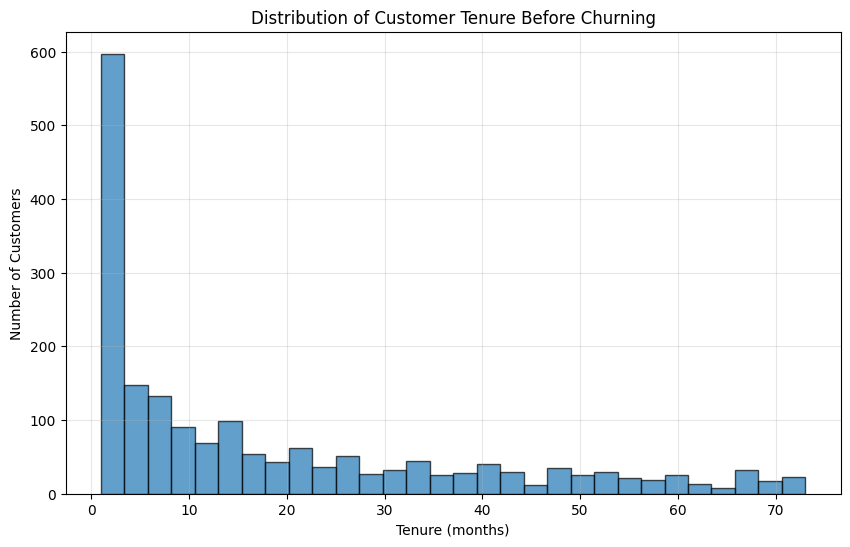

In [44]:
plt.figure(figsize=(10, 6))
plt.hist(tenure_months, bins=30, edgecolor='black', alpha=0.7)
plt.xlabel('Tenure (months)')
plt.ylabel('Number of Customers')
plt.title('Distribution of Customer Tenure Before Churning')
plt.grid(True, alpha=0.3)
plt.show()

the graph shows a 10-month threshold. This pattern suggests there might be a customer lifecycle where those who survive the initial period become much more loyal. 

In [51]:
churned_customers

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,tenure_month
2,3668-QPYBK,2019-10-01,2019-12-01,Month-to-month,Yes,Mailed check,53.85,108.15,2
4,9237-HQITU,2019-09-01,2019-11-01,Month-to-month,Yes,Electronic check,70.70,151.65,2
5,9305-CDSKC,2019-03-01,2019-11-01,Month-to-month,Yes,Electronic check,99.65,820.5,8
8,7892-POOKP,2017-07-01,2019-11-01,Month-to-month,Yes,Electronic check,104.80,3046.05,28
13,0280-XJGEX,2015-09-01,2019-10-01,Month-to-month,Yes,Bank transfer (automatic),103.70,5036.3,50
...,...,...,...,...,...,...,...,...,...
7021,1699-HPSBG,2018-11-01,2019-11-01,One year,Yes,Electronic check,59.80,727.8,12
7026,8775-CEBBJ,2019-02-01,2019-11-01,Month-to-month,Yes,Bank transfer (automatic),44.20,403.35,9
7032,6894-LFHLY,2019-10-01,2019-11-01,Month-to-month,Yes,Electronic check,75.75,75.75,1
7034,0639-TSIQW,2014-03-01,2019-10-01,Month-to-month,Yes,Credit card (automatic),102.95,6886.25,68


In [47]:
# Group by tenure_month and calculate mean spending
grouped_data = churned_customers.groupby('tenure_month')['monthlycharges'].mean()
print(grouped_data)

tenure_month
1     58.197368
2     65.924390
3     66.010638
4     70.635542
5     71.269531
        ...    
69    98.005556
70    99.450000
71    97.645455
72    95.133333
73    96.875000
Name: monthlycharges, Length: 72, dtype: float64


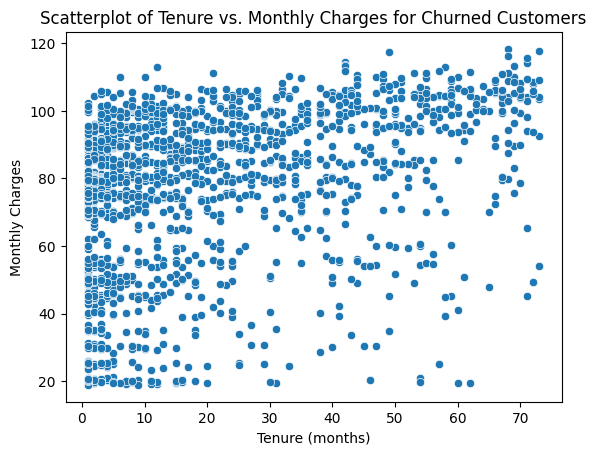

In [ ]:
sns.scatterplot(x='tenure_month', y='monthlycharges', data=churned_customers)
plt.title('Scatterplot of Tenure vs. Monthly Charges for Churned Customers')
plt.xlabel('Tenure (months)')
plt.ylabel('Monthly Charges')
plt.show()

highest concentration of data points are in the first 10 months and the monthly charges are less than 110 but as the tenure months increase so does the concentration monthly charges. The longer the customer sticks around the more they end up spending on a monthly basis.

Since most churned customers had very short tenures (0-10 months), this suggest onboarding experience or initial service satisfaction is poor.

the spending-tenure relationship: I noticed that longer-tenured customers who eventually churned were paying higher monthly charges. This is intriguing - why would customers who were willing to pay more and stayed longer would eventually leave? maybe they get bad service or the monthly charges keep adding up. loyalty discounts like consistant payment discounts could be applied.

it seems like there might be two distinct groups of churned customers - the early leavers (low tenure, varied charges) and the long-term leavers (higher tenure, higher charges). 

In [18]:
churned_customers['monthlycharges'].mean()

74.44133226324237

In [19]:
active_customers['monthlycharges'].mean()

61.26512369540008

In [20]:
tc_churned = churned_customers[churned_customers['totalcharges'] != '']['totalcharges']

tc_active = active_customers[active_customers['totalcharges'] != '']['totalcharges']

In [21]:
pd.to_numeric(tc_churned).mean().round(2)

1531.8

In [18]:
pd.to_numeric(tc_active, errors='coerce').mean().round(2)


2555.34

In [ ]:
# Looking for values that don't look like numbers
non_numeric = df_contract['totalcharges'][~df_contract['totalcharges'].str.replace('.', '').str.isdigit()]
print(f"Non-numeric values found: {len(non_numeric)}")
print(non_numeric.unique())

Non-numeric values found: 11
[' ']


In [20]:
df_contract_clean = df_contract[df_contract['totalcharges'].str.replace('.', '').str.isdigit()]

In [21]:
print(f"Original dataset: {len(df_contract)} rows")
print(f"After removing missing totalcharges: {len(df_contract_clean)} rows")
print(f"Removed: {len(df_contract) - len(df_contract_clean)} rows")

Original dataset: 7043 rows
After removing missing totalcharges: 7032 rows
Removed: 11 rows


In [22]:
df_contract_clean = df_contract_clean.copy()
df_contract_clean['totalcharges'] = df_contract_clean['totalcharges'].astype(float)

<AxesSubplot:xlabel='churned', ylabel='totalcharges'>

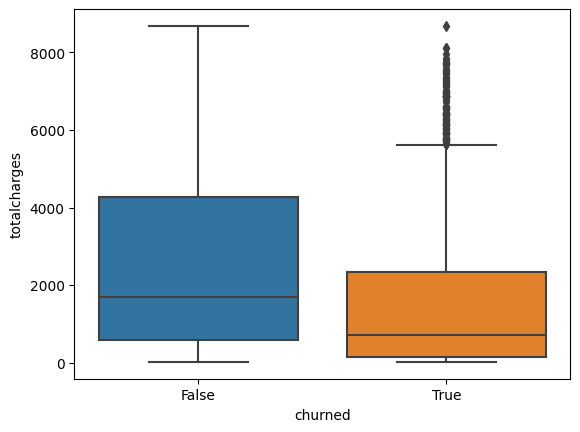

In [23]:
df_contract_clean['churned'] = df_contract_clean['enddate'] != 'No'
sns.boxplot(data=df_contract_clean, x='churned', y='totalcharges')

the median is lower for churned customers but there are many outliers that show monthly spending above 8000.00.
this could be from late fees and accumulating a large monthly balance. 
different customers show different spending budgets so a one size fits all plan might have an effect.
another plan may have to be implimented for a lower budget friendly layout.

<AxesSubplot:xlabel='churned', ylabel='monthlycharges'>

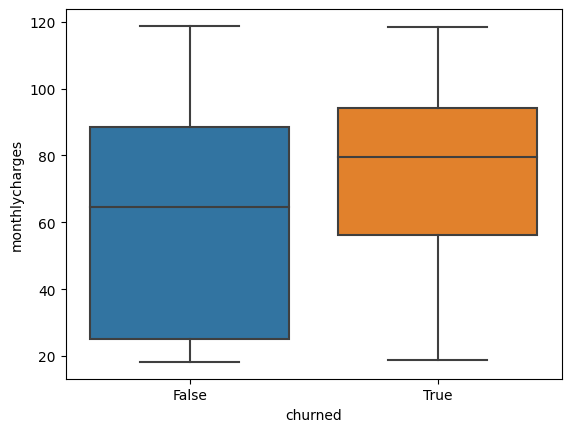

In [24]:
sns.boxplot(data=df_contract_clean, x='churned', y='monthlycharges')

the monthly median is actually higher for the churned customers.
possibly having late fees each month adding up. 
the average is also higher so someone spending so much per month may be likely to leave if they arent getting what they think they deserve for their money.

### personal

In [25]:
df_personal.columns = df_personal.columns.str.lower()

In [26]:
df_personal.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7043 entries, 0 to 7042
Data columns (total 5 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     7043 non-null   object
 1   gender         7043 non-null   object
 2   seniorcitizen  7043 non-null   int64 
 3   partner        7043 non-null   object
 4   dependents     7043 non-null   object
dtypes: int64(1), object(4)
memory usage: 275.2+ KB


In [27]:
df_personal.duplicated().sum()

0

In [28]:
df_personal.isna().sum()

customerid       0
gender           0
seniorcitizen    0
partner          0
dependents       0
dtype: int64

### Phone

In [29]:
df_phone.head()

,customerID,MultipleLines
0,5575-GNVDE,No
1,3668-QPYBK,No
2,9237-HQITU,No
3,9305-CDSKC,Yes
4,1452-KIOVK,Yes


In [30]:
df_phone.columns = df_phone.columns.str.lower()

In [31]:
df_phone.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6361 entries, 0 to 6360
Data columns (total 2 columns):
 #   Column         Non-Null Count  Dtype 
---  ------         --------------  ----- 
 0   customerid     6361 non-null   object
 1   multiplelines  6361 non-null   object
dtypes: object(2)
memory usage: 99.5+ KB


In [32]:
df_phone.duplicated().sum()

0

In [33]:
df_phone.isna().sum()

customerid       0
multiplelines    0
dtype: int64

### internet

In [34]:
df_internet.head()

,Unnamed: 0,id,mb_used,session_date,user_id
0,0,1000_0,112.95,2018-11-25,1000
1,1,1000_1,1052.81,2018-09-07,1000
2,2,1000_2,1197.26,2018-06-25,1000
3,3,1000_3,550.27,2018-08-22,1000
4,4,1000_4,302.56,2018-09-24,1000


In [35]:
df_internet.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 149396 entries, 0 to 149395
Data columns (total 5 columns):
 #   Column        Non-Null Count   Dtype  
---  ------        --------------   -----  
 0   Unnamed: 0    149396 non-null  int64  
 1   id            149396 non-null  object 
 2   mb_used       149396 non-null  float64
 3   session_date  149396 non-null  object 
 4   user_id       149396 non-null  int64  
dtypes: float64(1), int64(2), object(2)
memory usage: 5.7+ MB


In [36]:
df_internet.duplicated().sum()

0

In [37]:
df_internet.isna().sum()

Unnamed: 0      0
id              0
mb_used         0
session_date    0
user_id         0
dtype: int64

## Preprocessing

In [38]:
df_phone = df_phone.rename(columns={'multiplelines': 'phone_service'})

In [39]:
df_phone['phone_service'] = 1
df_phone

,customerid,phone_service
0,5575-GNVDE,1
1,3668-QPYBK,1
2,9237-HQITU,1
3,9305-CDSKC,1
4,1452-KIOVK,1
...,...,...
6356,2569-WGERO,1
6357,6840-RESVB,1
6358,2234-XADUH,1
6359,8361-LTMKD,1


In [40]:
df_contract_clean['churned']=df_contract_clean['churned'].astype(int)

In [41]:
merged_df = pd.merge(df_contract_clean, df_personal, on='customerid', how='inner')

final_df = pd.merge(merged_df, df_phone, on='customerid', how='left')

In [42]:
final_df['phone_service']=final_df['phone_service'].fillna(0)

In [43]:
final_df

,customerid,begindate,enddate,type,paperlessbilling,paymentmethod,monthlycharges,totalcharges,churned,gender,seniorcitizen,partner,dependents,phone_service
0,7590-VHVEG,2020-01-01,No,Month-to-month,Yes,Electronic check,29.85,29.85,0,Female,0,Yes,No,0.0
1,5575-GNVDE,2017-04-01,No,One year,No,Mailed check,56.95,1889.50,0,Male,0,No,No,1.0
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,Month-to-month,Yes,Mailed check,53.85,108.15,1,Male,0,No,No,1.0
3,7795-CFOCW,2016-05-01,No,One year,No,Bank transfer (automatic),42.30,1840.75,0,Male,0,No,No,0.0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,Month-to-month,Yes,Electronic check,70.70,151.65,1,Female,0,No,No,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,No,One year,Yes,Mailed check,84.80,1990.50,0,Male,0,Yes,Yes,1.0
7028,2234-XADUH,2014-02-01,No,One year,Yes,Credit card (automatic),103.20,7362.90,0,Female,0,Yes,Yes,1.0
7029,4801-JZAZL,2019-03-01,No,Month-to-month,Yes,Electronic check,29.60,346.45,0,Female,0,Yes,Yes,0.0
7030,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,Month-to-month,Yes,Mailed check,74.40,306.60,1,Male,1,Yes,No,1.0


In [42]:
df_encoded = pd.get_dummies(final_df, columns=['gender', 'partner', 'dependents','type','paperlessbilling','paymentmethod'])
df_encoded

,customerid,begindate,enddate,monthlycharges,totalcharges,churned,seniorcitizen,phone_service,gender_Female,gender_Male,...,dependents_Yes,type_Month-to-month,type_One year,type_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,7590-VHVEG,2020-01-01,No,29.85,29.85,0,0,0.0,1,0,...,0,1,0,0,0,1,0,0,1,0
1,5575-GNVDE,2017-04-01,No,56.95,1889.50,0,0,1.0,0,1,...,0,0,1,0,1,0,0,0,0,1
2,3668-QPYBK,2019-10-01,2019-12-01 00:00:00,53.85,108.15,1,0,1.0,0,1,...,0,1,0,0,0,1,0,0,0,1
3,7795-CFOCW,2016-05-01,No,42.30,1840.75,0,0,0.0,0,1,...,0,0,1,0,1,0,1,0,0,0
4,9237-HQITU,2019-09-01,2019-11-01 00:00:00,70.70,151.65,1,0,1.0,1,0,...,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,6840-RESVB,2018-02-01,No,84.80,1990.50,0,0,1.0,0,1,...,1,0,1,0,0,1,0,0,0,1
7028,2234-XADUH,2014-02-01,No,103.20,7362.90,0,0,1.0,1,0,...,1,0,1,0,0,1,0,1,0,0
7029,4801-JZAZL,2019-03-01,No,29.60,346.45,0,0,0.0,1,0,...,1,1,0,0,0,1,0,0,1,0
7030,8361-LTMKD,2019-07-01,2019-11-01 00:00:00,74.40,306.60,1,1,1.0,0,1,...,0,1,0,0,0,1,0,0,0,1


### encoding

In [44]:
df_encoded=df_encoded.drop(['begindate','enddate','customerid'], axis=1).drop_duplicates()
df_encoded

,monthlycharges,totalcharges,churned,seniorcitizen,phone_service,gender_Female,gender_Male,partner_No,partner_Yes,dependents_No,dependents_Yes,type_Month-to-month,type_One year,type_Two year,paperlessbilling_No,paperlessbilling_Yes,paymentmethod_Bank transfer (automatic),paymentmethod_Credit card (automatic),paymentmethod_Electronic check,paymentmethod_Mailed check
0,29.85,29.85,0,0,0.0,1,0,0,1,1,0,1,0,0,0,1,0,0,1,0
1,56.95,1889.50,0,0,1.0,0,1,1,0,1,0,0,1,0,1,0,0,0,0,1
2,53.85,108.15,1,0,1.0,0,1,1,0,1,0,1,0,0,0,1,0,0,0,1
3,42.30,1840.75,0,0,0.0,0,1,1,0,1,0,0,1,0,1,0,1,0,0,0
4,70.70,151.65,1,0,1.0,1,0,1,0,1,0,1,0,0,0,1,0,0,1,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7027,84.80,1990.50,0,0,1.0,0,1,0,1,0,1,0,1,0,0,1,0,0,0,1
7028,103.20,7362.90,0,0,1.0,1,0,0,1,0,1,0,1,0,0,1,0,1,0,0
7029,29.60,346.45,0,0,0.0,1,0,0,1,0,1,1,0,0,0,1,0,0,1,0
7030,74.40,306.60,1,1,1.0,0,1,0,1,1,0,1,0,0,0,1,0,0,0,1


## Features and Target

In [46]:
X = df_encoded.drop('churned', axis=1)
y = df_encoded['churned']

In [ ]:
# Initial split 
X_train, X_temp, y_train, y_temp = train_test_split(X, y, shuffle=False, test_size=0.1, random_state=42)

# Test split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, shuffle=False, test_size=0.1, random_state=42)

## Hyper Tuning

### Random Forest Classifier

In [51]:
param_grid = {
    'n_estimators': [10, 100, 200],
    'max_depth': [4, 5, 10, None],
    'max_features': [1, 3, 5, 7],
    'min_samples_split': [10, 20, 30]
}

rf = RandomForestClassifier()
grid_search_rf = GridSearchCV(estimator=rf, param_grid=param_grid, cv=5, scoring='roc_auc')

grid_search_rf.fit(X_train, y_train)

print(f'Best parameters: {grid_search_rf.best_params_}')
print(f'Best cross-validation score: {grid_search_rf.best_score_}')

Best parameters: {'max_depth': 10, 'max_features': 7, 'min_samples_split': 30, 'n_estimators': 200}
Best cross-validation score: 0.8369406927745915


Best parameters: {'max_depth': 4, 'max_features': 5, 'min_samples_split': 30, 'n_estimators': 200}
Best cross-validation score: 0.8031351381357414

Test AUC-ROC Score: 0.7424

### Decision Tree Classifier

In [52]:
param_grid = {
    'max_depth': [None, 4, 5],
    'min_samples_split': [9, 5, 13]
}

grid_search_dt = GridSearchCV(DecisionTreeClassifier(random_state=0), param_grid, cv=5)
grid_search_dt.fit(X_train, y_train)

print(f'Best parameters: {grid_search_dt.best_params_}')
print(f'Best cross-validation score: {grid_search_dt.best_score_}')

Best parameters: {'max_depth': 5, 'min_samples_split': 9}
Best cross-validation score: 0.7866619210859886


Best parameters: {'max_depth': 4, 'min_samples_split': 9}
Best cross-validation score: 0.7683307419965157

### Compare

In [53]:
models = {
    'Decision Tree': DecisionTreeClassifier(max_depth=4, min_samples_split=9, random_state=42,),
    'Random Forest': RandomForestClassifier(max_depth=6, max_features=5, min_samples_split=10, n_estimators=11, random_state=42,),
    'Logistic Regression': LogisticRegression(max_iter=2000, random_state=42)
}

cv_results = {}
for model_name, model in models.items():
    scores = cross_val_score(model, X_train, y_train, cv=5, scoring='roc_auc')
    cv_results[model_name] = scores
    mean_score = scores.mean()
    std_dev = scores.std()
    print(f'{model_name} Cross-Validation Accuracy: {mean_score:.4f} ± {std_dev:.4f}')


best_model_name = max(cv_results, key=lambda k: cv_results[k].mean())
best_model = models[best_model_name]

print(f'Best Model: {best_model_name}')

Decision Tree Cross-Validation Accuracy: 0.8181 ± 0.0131
Random Forest Cross-Validation Accuracy: 0.8314 ± 0.0074
Logistic Regression Cross-Validation Accuracy: 0.8307 ± 0.0071
Best Model: Random Forest


### XGBoost

In [54]:
# Parameter grid
xgb_param_grid = {
    'n_estimators': [20, 30],
    'max_depth': [3, 4, 5],
    'learning_rate': [0.01, 0.1, 0.2]
}

# Initialize the model
xgb_model = XGBClassifier(random_state=42)

# Random search setup
random_search = RandomizedSearchCV(xgb_model, xgb_param_grid, n_iter=10, cv=5, n_jobs=-1, scoring='roc_auc')

# Fit
random_search.fit(X_train, y_train)
best_xgb = random_search.best_estimator_

# Get probability predictions (not class predictions)
val_predictions = best_xgb.predict_proba(X_val)[:, 1]

# Calculate AUC-ROC
val_auc = roc_auc_score(y_val, val_predictions)

print(f"XGBoost - Validation AUC-ROC: {val_auc}")

/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/.venv/lib/python3.9/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClas

[02:57:01] WARNING: ../src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
XGBoost - Validation AUC-ROC: 0.8468333499104834


In [55]:
print(f"Best parameters: {random_search.best_params_}")

Best parameters: {'n_estimators': 30, 'max_depth': 3, 'learning_rate': 0.2}


## Test Model

In [56]:
test_predictions = grid_search_rf.best_estimator_.predict(X_test)

test_probabilities = grid_search_rf.best_estimator_.predict_proba(X_test)

churn_probabilities = test_probabilities[:, 1]

auc_score = roc_auc_score(y_test, churn_probabilities)

In [57]:
test_predictions = grid_search_rf.best_estimator_.predict_proba(X_test)

print(f'Test AUC-ROC Score: {auc_score:.4f}')

if auc_score >= 0.75:
    print(f'The model meets the auc_score threshold of 0.75 with an auc_score of {auc_score:.4f}')
else:
    print(f'The model does not meet the auc_score threshold. auc_score: {auc_score:.4f}')

Test AUC-ROC Score: 0.8016
The model meets the auc_score threshold of 0.75 with an auc_score of 0.8016


In [66]:
# Test the final model
test_predictions = best_xgb.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_predictions)

print(f"XGBoost - Test AUC-ROC: {test_auc}")

if auc_score >= 0.75:
    print(f'The model meets the auc_score threshold of 0.75 with an auc_score of {test_auc:.4f}')
else:
    print(f'The model does not meet the auc_score threshold. auc_score: {test_auc:.4f}')

XGBoost - Test AUC-ROC: 0.7894736842105263
The model meets the auc_score threshold of 0.75 with an auc_score of 0.7895


In [68]:
# Test the final model
test_predictions = grid_search_dt.predict_proba(X_test)[:, 1]
test_auc = roc_auc_score(y_test, test_predictions)

print(f"XGBoost - Test AUC-ROC: {test_auc}")

if auc_score >= 0.75:
    print(f'The model meets the auc_score threshold of 0.75 with an auc_score of {test_auc:.4f}')
else:
    print(f'The model does not meet the auc_score threshold. auc_score: {test_auc:.4f}')

XGBoost - Test AUC-ROC: 0.7935222672064778
The model meets the auc_score threshold of 0.75 with an auc_score of 0.7935


## Conclusion

correlation - the fact that charges directly correlate with churn tells us something powerful about customer behavior. This suggests customers might be churning due to cost sensitivity or value perception issues.

random forest
Test AUC-ROC Score: 0.8016

Detection: Model identifies at-risk customers (high total charges + other risk factors)
Immediate Intervention: Automatic yearly plan offer with 10% discount
Retention + Growth: Locked contract creates stability AND upselling opportunities
Continuous Learning: Monitor and refine based on real performance data

we now have the power to be proactive. my model gives us advance warning, which transforms how the business operates.

Strategic Planning Benefits:

With this predictive capability, what kinds of business planning become possible that weren't before? Think about:

Resource allocation
Revenue forecasting
Customer service capacity
Marketing budget distribution
The Bigger Picture:

This connects back to why your 0.8016 AUC-ROC score was so important - it's not just a technical achievement, it's business intelligence that enables strategic planning. 

Segmentation strategy: Based on the model's performance, there should be a more incentivised plan that makes it more affordable. maybe a yearly plan thats more affordable than a month to month.there should be an offer before the customer is at risk of churning but as soon as they show the signs of being at risk with high total charges. the long term contract will keep them locked in and will present more chances of upgrading or expanding on their services, adding to their plan.